# Data Loading

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import re
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from collections import Counter
import itertools

#### Functions to process data

In [3]:
# Functions used to convert data

# Binary conversion - 
def yesNoBinaryConversion(input):    
    input.replace('yes', 1, inplace = True)
    input.replace('no', 0, inplace = True)
    
def weightReplacement(input):        
    replace_dicitonary = {r"\binsufficient": '0',
                        r"\bnormal": '1',
                       r"\boverweight": '2',
                        r"\bobesity": '3'}
    for index, value in enumerate(input):
        for key, item in replace_dicitonary.items():                 
            find_ = re.findall(key,value,re.I)
            if find_:
                input.replace(value, item, inplace=True)
                
def integerBuckets(input):
    for index, value in enumerate(input):
        if value > 2.4:
            input.replace(value, 3, inplace = True)
        elif value > 1.7:
            input.replace(value, 2, inplace = True)
        else:
            input.replace(value, 1, inplace = True)

def categoricalBuckets(input):
    for index, value in enumerate(input):
        if value > 2.5:
            input.replace(value, 'Always', inplace = True)
        elif value > 1.5:
            input.replace(value, 'Frequently', inplace = True)
        else:
            input.replace(value, 'Sometimes', inplace = True)
            
def integer_3_Buckets(input):
    for index, value in enumerate(input):
        if value > 1.4:
            input.replace(value, 2, inplace = True)
        elif value > 0.7:
            input.replace(value, 1, inplace = True)
        else:
            input.replace(value, 0, inplace = True)

def ageRounding(input):
    for index, value in enumerate(input):
        input.replace(value, round(value, 0), inplace = True)
        
def h2oRounding(input):
    for index, value in enumerate(input):
        if value > 2.5:
            input.replace(value, 3, inplace = True)
        elif value > 1.5:
            input.replace(value, 2, inplace = True)
        else:
            input.replace(value, 1, inplace = True)
            
def activityRounding(input):
    for index, value in enumerate(input):
        if value > 2.4:
            input.replace(value, 3, inplace = True)
        elif value > 1.7:
            input.replace(value, 2, inplace = True)
        elif value > 0.7:
            input.replace(value, 1, inplace = True)
        else:
            input.replace(value, 0, inplace = True)

def neuralNetworkModel(dataFrame, tag, weight_question):
    # Split our preprocessed data into our features and target arrays
    X = dataFrame.drop(['Obesity_Level'], axis=1).values
    y = dataFrame['Obesity_Level'].values

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    ## Compile, Train and Evaluate the Model
    input_features = X_train_scaled.shape[1]
    
    activation_functions= ['relu', 'softmax', 'selu']
    neurons= range(25,40,5)
    hidden_layers= range(2,4)
    
    for activations in activation_functions:
        for neuron in neurons:
            for layer in hidden_layers:
                
                nn_keras_model = tf.keras.models.Sequential()
                
                nn_keras_model.add(tf.keras.layers.Dense(units=56, activation= activations, input_dim= input_features))
                
                for _ in itertools.repeat(None, int(layer)):
                    #Add hidden layers                                  
                    nn_keras_model.add(tf.keras.layers.Dense(units=int(neuron), activation= activations))

            # Output layer
                nn_keras_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

                # Check the structure of the model
                nn_keras_model.summary()

                # Compile the model
                nn_keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

                # Train the model
                fit_model = nn_keras_model.fit(X_train_scaled, y_train, epochs=60)

                # Evaluate the model using the test data
                model_loss, model_accuracy = nn_keras_model.evaluate(X_test_scaled,y_test,verbose=2)
                print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
                
                nn_outcome_dictionary['Network_Model'].append(tag)
                nn_outcome_dictionary["Height_&_Weight"].append(weight_question)
                nn_outcome_dictionary['Accuracy'].append(model_accuracy)
                nn_outcome_dictionary['Loss'].append(model_loss)
                nn_outcome_dictionary['Hidden_Layers'].append(layer)
                nn_outcome_dictionary['Activation_Function'].append(activations)
                nn_outcome_dictionary['Neurons'].append(neuron)

def neuralNetworkModelNoHeightWeight(dataFrame, tag, weight_question):
    # Split our preprocessed data into our features and target arrays
    X = dataFrame.drop(['Obesity_Level', 'Height', 'Weight', 'BMI'], axis=1).values
    y = dataFrame['Obesity_Level'].values

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    ## Compile, Train and Evaluate the Model
    input_features = X_train_scaled.shape[1]

    activation_functions= ['relu', 'softmax', 'selu']
    neurons= range(25,40,5)
    hidden_layers= range(2,4)
    
    for activations in activation_functions:
        for neuron in neurons:
            for layer in hidden_layers:
                
                nn_keras_model = tf.keras.models.Sequential()
                
                nn_keras_model.add(tf.keras.layers.Dense(units=56, activation= activations, input_dim= input_features))
                
                for _ in itertools.repeat(None, int(layer)):
                    #Add hidden layers                                  
                    nn_keras_model.add(tf.keras.layers.Dense(units=int(neuron), activation= activations))

            # Output layer
                nn_keras_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

                # Check the structure of the model
                nn_keras_model.summary()

                # Compile the model
                nn_keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

                # Train the model
                fit_model = nn_keras_model.fit(X_train_scaled, y_train, epochs=60)

                # Evaluate the model using the test data
                model_loss, model_accuracy = nn_keras_model.evaluate(X_test_scaled,y_test,verbose=2)
                print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
                
                nn_outcome_dictionary['Network_Model'].append(tag)
                nn_outcome_dictionary["Height_&_Weight"].append(weight_question)
                nn_outcome_dictionary['Accuracy'].append(model_accuracy)
                nn_outcome_dictionary['Loss'].append(model_loss)
                nn_outcome_dictionary['Hidden_Layers'].append(layer)
                nn_outcome_dictionary['Activation_Function'].append(activations)
                nn_outcome_dictionary['Neurons'].append(neuron)

## Feature Analysis & Processing

#### Initiate spark object

In [4]:
# Initiate spark
findspark.init()

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\pyspark\context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


#### Fetch data

In [5]:
# Read in obesity data from S3 Bucket as a spark object
url = "https://project-4-weight-data.s3.ap-southeast-2.amazonaws.com/ObesityDataSet_raw_and_data_synthetic.csv"
spark.sparkContext.addFile(url)

# DataFrame is called df
raw_obesity_data = (spark.read.csv(SparkFiles.get("ObesityDataSet_raw_and_data_synthetic.csv"), sep=",", header=True)).toPandas()

In [6]:
# fetch dataset variable information

estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 

In [7]:
# Define our raw feature & target data
raw_feature_data = raw_obesity_data.drop('NObeyesdad', axis= 1).copy()

raw_target_data = raw_obesity_data.drop(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'], axis= 1).copy()

#### Fetch datatype conversion table

In [8]:
# Read in datatypes csv
dtype_url = "https://project-4-weight-data.s3.ap-southeast-2.amazonaws.com/database_dtype.csv"
spark.sparkContext.addFile(dtype_url)

# DataFrame is called datatypes
datatypes = (spark.read.csv(SparkFiles.get("database_dtype.csv"), sep=",", header=True)).toPandas()

# Replace datatypes in dataframe to convert the feature/target dataframe
datatypes.replace(['uint8', 'int32'], 'int64')

datatype_dict= {}

for index, row in datatypes.iterrows():
    try:        
        datatype_dict[row['Feature']]= row['Dtype']
    except:
        pass
    
# Convert datatypes
for key, value in datatype_dict.items():
    try:
        raw_feature_data[key] = raw_feature_data[key].astype(value) 
    except:
        pass

# Create new dataframe with data converted & target data
raw_complete_data= pd.concat([raw_feature_data, raw_target_data], axis= 1)

In [9]:
# Add a BMI column to features
raw_feature_data['BMI'] = raw_feature_data['Weight'] / (raw_feature_data['Height'] ** 2)

# As we're only looking at measuring overweight/obesity we'll combine normal & underweight into one category in the target data
raw_target_data.replace('Insufficient_Weight', 'Normal_Weight', inplace= True)

# Processing Feature Data

In [10]:
processed_feature_data = raw_feature_data.copy()

# Create a column which represents a known ratio of weight to height, i.e. BMI.
processed_feature_data['BMI'] = round(processed_feature_data['Weight'] / processed_feature_data['Height']**2, 3)

# Replace binary value types with 1 for yes, 0 for no for all binary type columns

binary_list = []

for index, row in estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition['variables'].iterrows():    
    
    
    if row['type'] == 'Binary':
        binary_list.append(row['name'])
        
for i in binary_list:
    yesNoBinaryConversion(processed_feature_data[i])
    
# Round the age to an integer.
ageRounding(processed_feature_data['Age'])

# Round off what water consumption onto 1.0, 2.0 or 3.0 to align with real world data
h2oRounding(processed_feature_data['CH2O'])

# Place the FCVC feature into buckets. FCVC is the question of regular fruit/veg consumption. 1 - Always, 2 - Frequently, 3 - Never
categoricalBuckets(processed_feature_data['FCVC'])

# Place the NCP feature into buckets. NCP is the question of how many meals per day.
integerBuckets(processed_feature_data['NCP'])

# Place the TUE feature into buckets. TUE is the question of how much screen time per day.
integer_3_Buckets(processed_feature_data['TUE'])

# Place the FAF feature into buckets. FAF is the question of physical activity per day.
activityRounding(processed_feature_data['FAF'])

# Rename columns to better reflect feature data
processed_feature_data.rename(columns={
    'family_history_with_overweight': 'Overweight_Family_History',
    'FAVC': 'High_Caloric_Food_Frequency',
    'FCVC': 'Meal_Vegetable_Intake',
    'NCP': 'Main_Meals_per_Day',
    'CAEC': 'Food_Between_Meals',
    'SMOKE': 'Smoking_Status',
    'CH2O': 'Daily_Water_Intake_L',
    'SCC': 'Monitor_Calorie_Intake',
    'FAF': 'Physical_Activity',
    'TUE': 'Screentime_hrs',
    'CALC': 'Alcohol_Frequency',
    'MTRANS': 'Mode_of_Transportaion'},
    inplace=True)

# Use get_dummies to normalise categorical data in preparation for modelling
dummy_feature_data = pd.get_dummies(processed_feature_data)

## Exploratory Data Analysis (EDA)

In [11]:
# Normalise data using get_dummies and create a complete dataset with normalised data
feature_analysis_data = pd.get_dummies(raw_feature_data, drop_first=True)

normalised_raw_data = pd.concat([feature_analysis_data, raw_target_data], axis= 1)

eda_model_data= normalised_raw_data.copy()

eda_model_data.rename(columns={
    'family_history_with_overweight': 'Overweight_Family_History',
    'FAVC': 'High_Caloric_Food_Frequency',
    'FCVC': 'Meal_Vegetable_Intake',
    'NCP': 'Main_Meals_per_Day',
    'CAEC': 'Food_Between_Meals',
    'SMOKE': 'Smoking_Status',
    'CH2O': 'Daily_Water_Intake_L',
    'SCC': 'Monitor_Calorie_Intake',
    'FAF': 'Physical_Activity',
    'TUE': 'Screentime_hrs',
    'CALC': 'Alcohol_Frequency',
    'MTRANS': 'Mode_of_Transportaion'}, inplace=True)

eda_model_data['NObeyesdad'] = eda_model_data['NObeyesdad'].astype('category')

display(eda_model_data.tail())

,Age,Height,Weight,Meal_Vegetable_Intake,Main_Meals_per_Day,Daily_Water_Intake_L,Physical_Activity,Screentime_hrs,BMI,Gender_Male,...,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
2106,20.976842,1.710730,131.408528,3.0,3.0,1.728139,1.676269,0.906247,44.901475,0,...,0,0,0,1,0,0,0,1,0,Obesity_Type_III
2107,21.982942,1.748584,133.742943,3.0,3.0,2.005130,1.341390,0.599270,43.741923,0,...,0,0,0,1,0,0,0,1,0,Obesity_Type_III
2108,22.524036,1.752206,133.689352,3.0,3.0,2.054193,1.414209,0.646288,43.543817,0,...,0,0,0,1,0,0,0,1,0,Obesity_Type_III
2109,24.361936,1.739450,133.346641,3.0,3.0,2.852339,1.139107,0.586035,44.071535,0,...,0,0,0,1,0,0,0,1,0,Obesity_Type_III
2110,23.664709,1.738836,133.472641,3.0,3.0,2.863513,1.026452,0.714137,44.144338,0,...,0,0,0,1,0,0,0,1,0,Obesity_Type_III


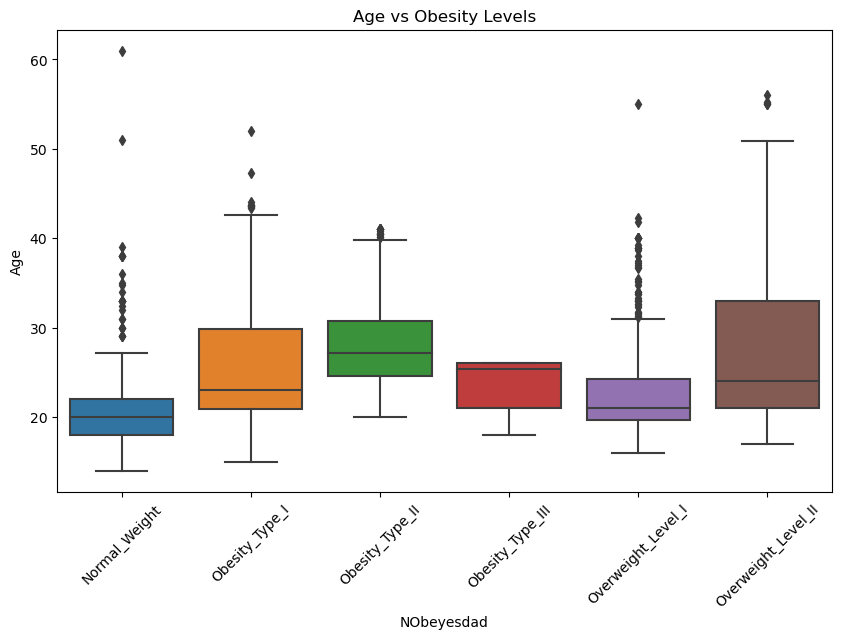

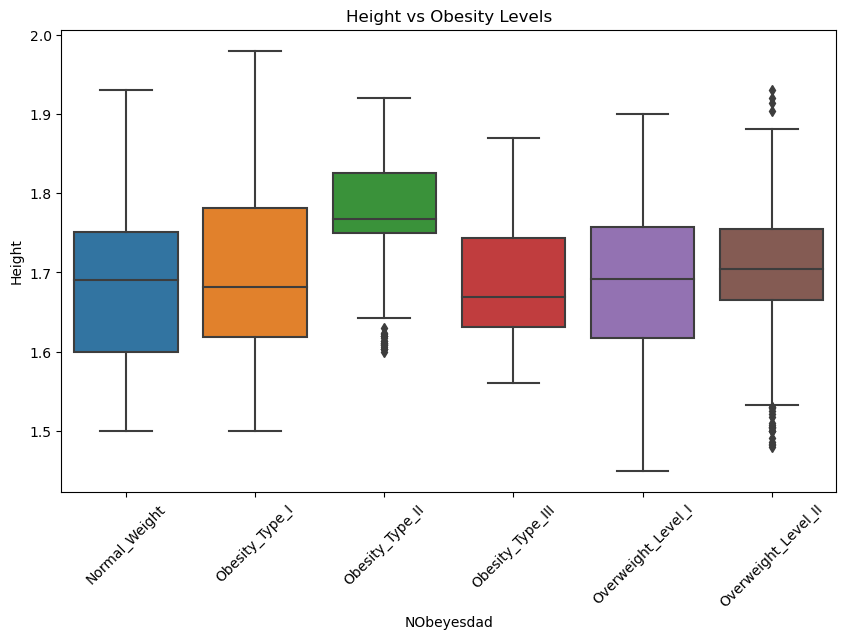

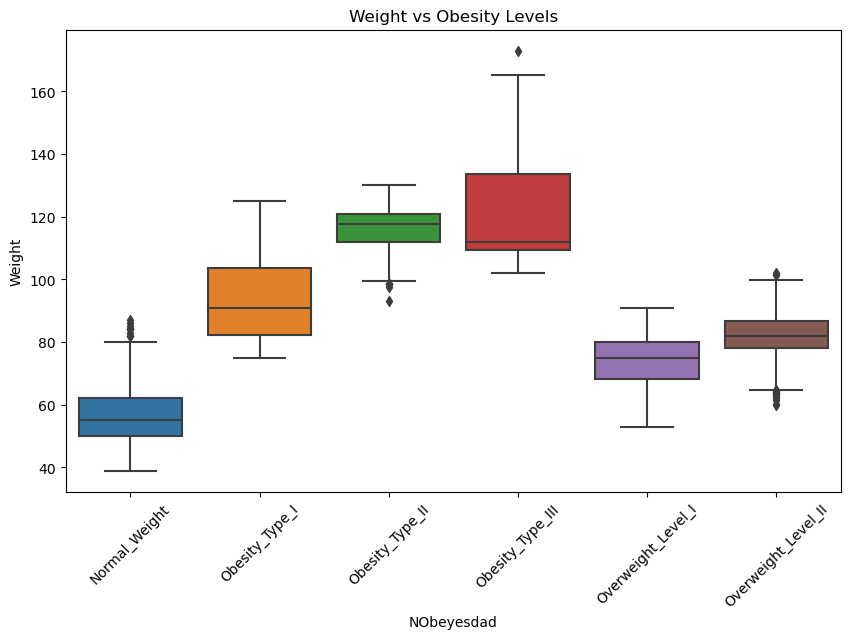

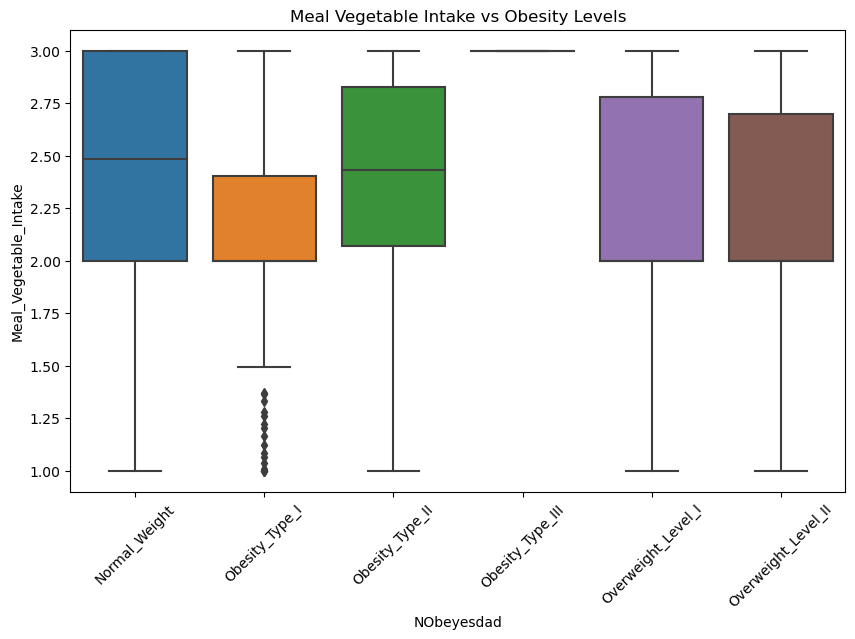

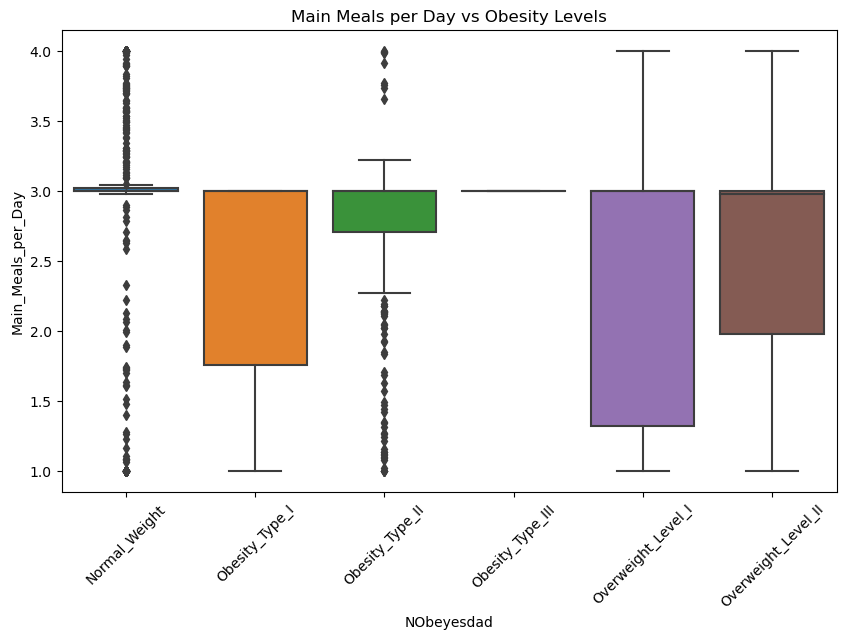

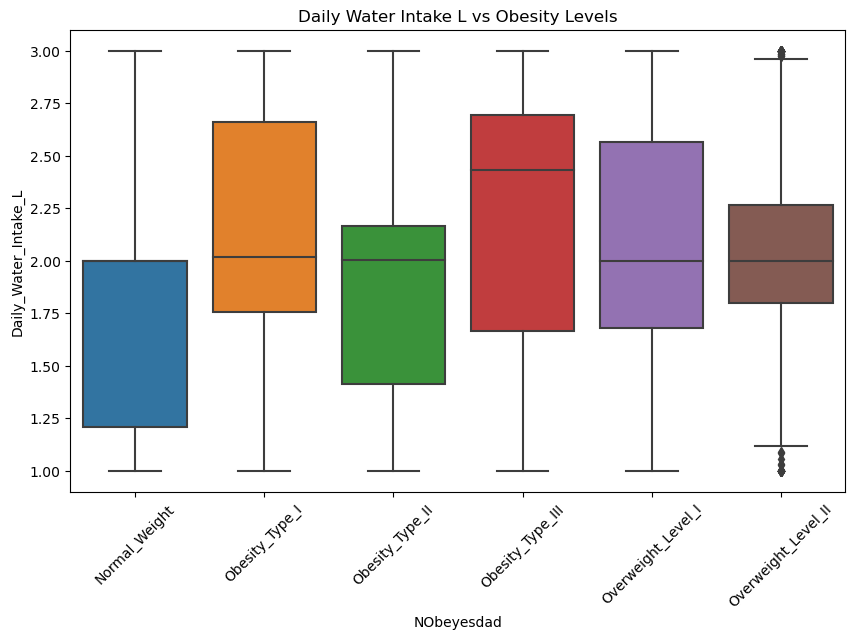

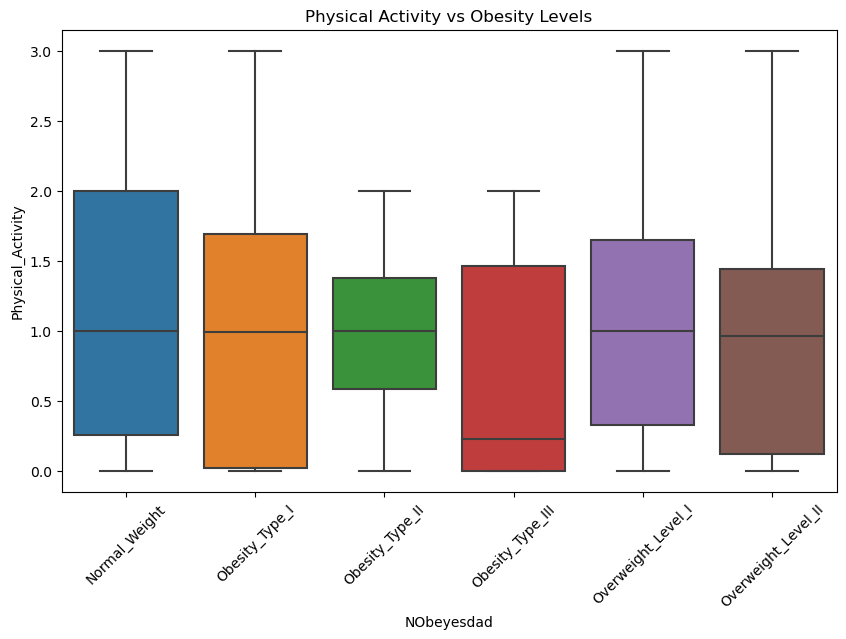

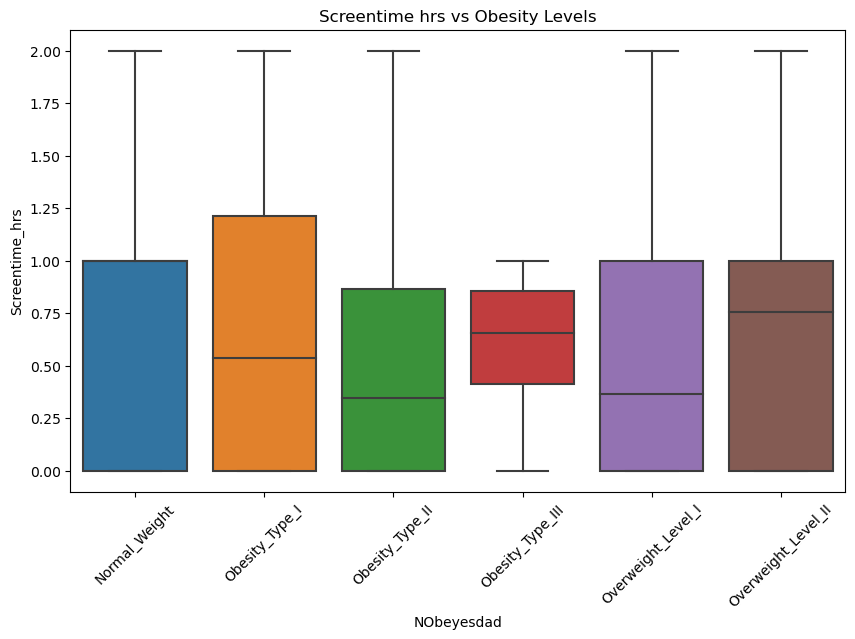

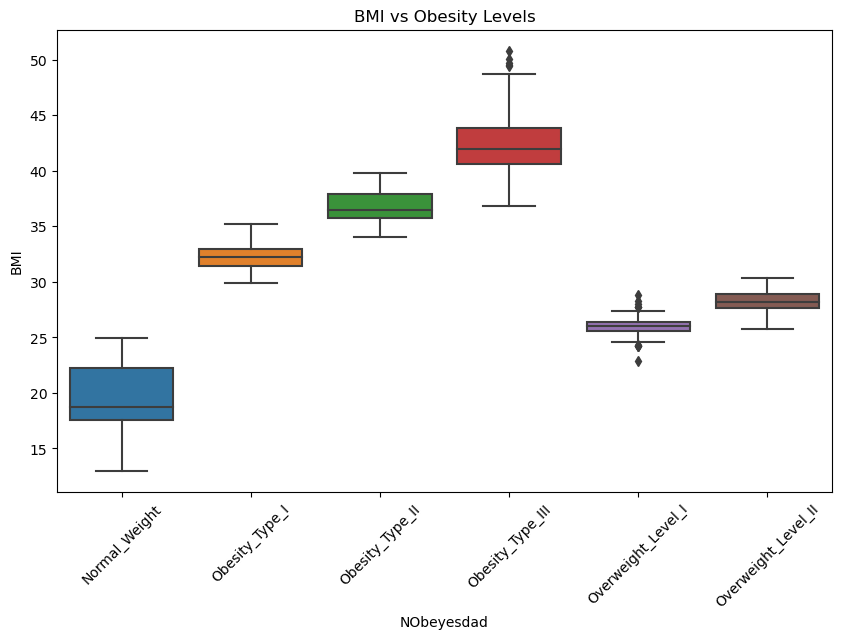

In [13]:
# Visualise the relationship between numeric features and obesity levels
numeric_columns = eda_model_data.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:  
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='NObeyesdad', y=column, data=eda_model_data)
    plt.title(f'{column.replace("_", " ")} vs Obesity Levels')
    plt.xticks(rotation=45)
    plt.savefig(f"Images/{column}vsObesity.png")
    plt.show()

In [14]:
# Create feature analysis dataframe
feature_analysis= raw_obesity_data.copy()

# Convert datatypes
for key, value in datatype_dict.items():
    try:
        feature_analysis[key] = feature_analysis[key].astype(value) 
    except:
        pass

feature_analysis.rename(columns={
    'family_history_with_overweight': 'Overweight_Family_History',
    'FAVC': 'High_Caloric_Food_Frequency',
    'FCVC': 'Meal_Vegetable_Intake',
    'NCP': 'Main_Meals_per_Day',
    'CAEC': 'Food_Between_Meals',
    'SMOKE': 'Smoking_Status',
    'CH2O': 'Daily_Water_Intake_L',
    'SCC': 'Monitor_Calorie_Intake',
    'FAF': 'Physical_Activity',
    'TUE': 'Screentime_hrs',
    'CALC': 'Alcohol_Frequency',
    'MTRANS': 'Mode_of_Transportaion',
    'NObeyesdad': 'Obesity_Level'}, inplace=True)

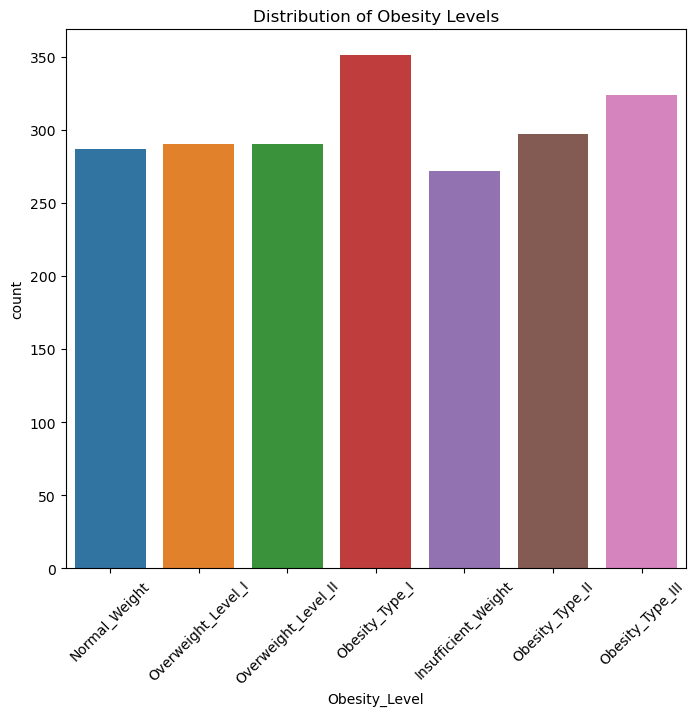

In [15]:
# Bar Plot of Obesity Levels
plt.figure(figsize=(8, 7))
sns.countplot(data=feature_analysis, x='Obesity_Level')
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=45)
plt.savefig('Images/obesity_levels_distribution.png', bbox_inches='tight')
plt.show()

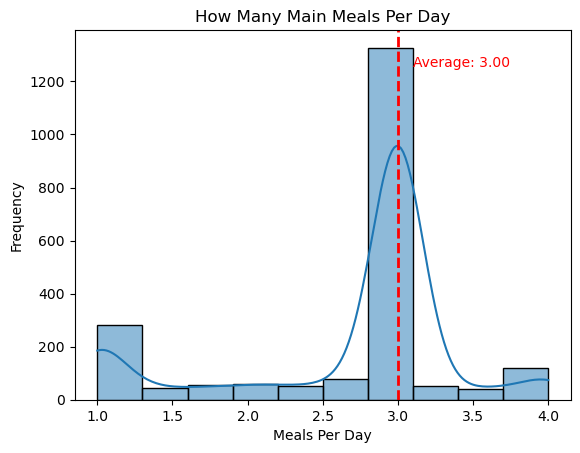

In [16]:
# Calculate the average number of main meals per day
average_meals_per_day = round(feature_analysis['Main_Meals_per_Day'].mean())

# Histogram showing How Many Main Meals Per Day
sns.histplot(data=feature_analysis, x='Main_Meals_per_Day', bins= 10, kde=True)
plt.title('How Many Main Meals Per Day')
plt.xlabel('Meals Per Day')
plt.ylabel('Frequency')

# Add the average line to the histogram
plt.axvline(average_meals_per_day, color='r', linestyle='dashed', linewidth=2)
plt.text(average_meals_per_day + 0.1, plt.ylim()[1] * 0.9, f'Average: {average_meals_per_day:.2f}', color='r')
plt.savefig('Images/meals_per_day_histogram.png')

plt.show()


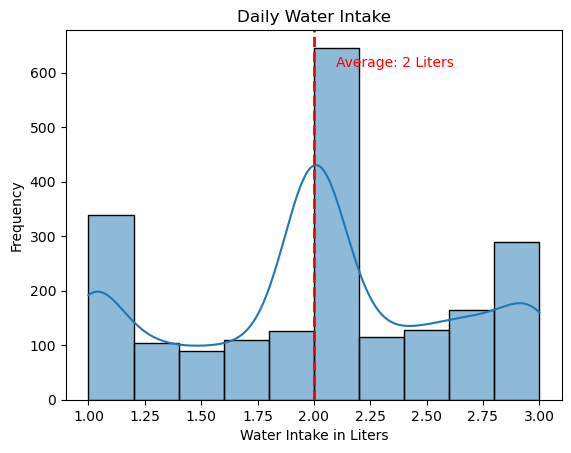

In [17]:
# Calculate the average daily water intake
average_water_intake = round(feature_analysis['Daily_Water_Intake_L'].mean())

# Histogram showing Daily Water Intake Per day
sns.histplot(data=feature_analysis, x='Daily_Water_Intake_L', bins= 10, kde=True)
plt.title('Daily Water Intake')
plt.xlabel('Water Intake in Liters')
plt.ylabel('Frequency')

# Add the average line to the histogram
plt.axvline(average_water_intake, color='r', linestyle='dashed', linewidth=2)
plt.text(average_water_intake + 0.1, plt.ylim()[1] * 0.9, f'Average: {average_water_intake} Liters', color='r')
plt.savefig('Images/daily_water_intake_histogram.png')

plt.show()


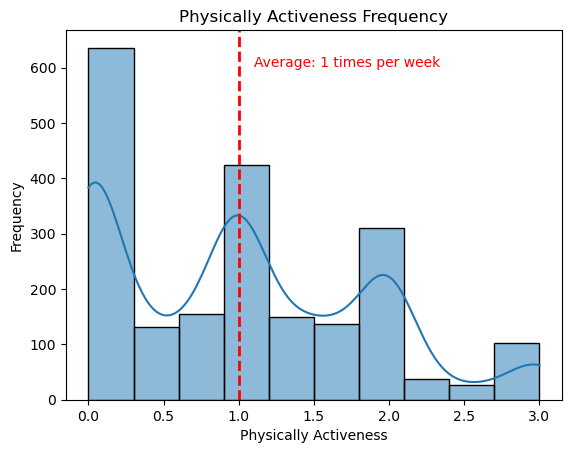

In [18]:
# Calculate the average physical activity frequency
average_physical_activity = round(feature_analysis['Physical_Activity'].mean())

# Histogram showing Are You Physically Active
sns.histplot(data=feature_analysis, x='Physical_Activity', bins= 10, kde=True)
plt.title('Physically Activeness Frequency')
plt.xlabel('Physically Activeness')
plt.ylabel('Frequency')

# Add the average line to the histogram
plt.axvline(average_physical_activity, color='r', linestyle='dashed', linewidth=2)
plt.text(average_physical_activity + 0.1, plt.ylim()[1] * 0.9, f'Average: {average_physical_activity} times per week', color='r')
plt.savefig('Images/physical_activity_histogram.png')
plt.show()


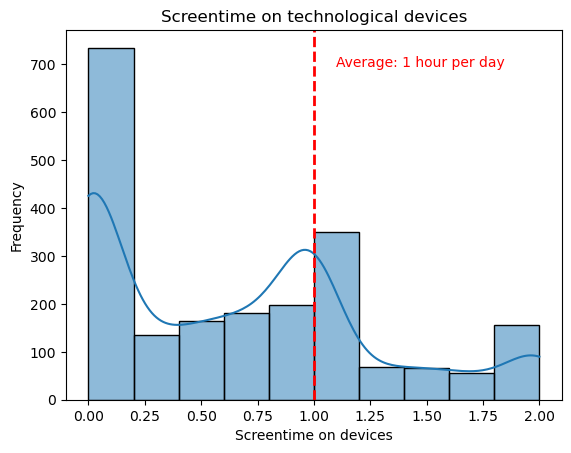

In [19]:
# Calculate the average screentime on technological devices
average_screentime = round(feature_analysis['Screentime_hrs'].mean())

# Histogram showing Screentime on technological devices
sns.histplot(data=feature_analysis, x='Screentime_hrs', bins= 10, kde=True)
plt.title('Screentime on technological devices')
plt.xlabel('Screentime on devices')
plt.ylabel('Frequency')

# Add the average line to the histogram
plt.axvline(average_screentime, color='r', linestyle='dashed', linewidth=2)
plt.text(average_screentime + 0.1, plt.ylim()[1] * 0.9, f'Average: {average_screentime} hour per day', color='r')
plt.savefig('Images/screentime_histogram.png')
plt.show()


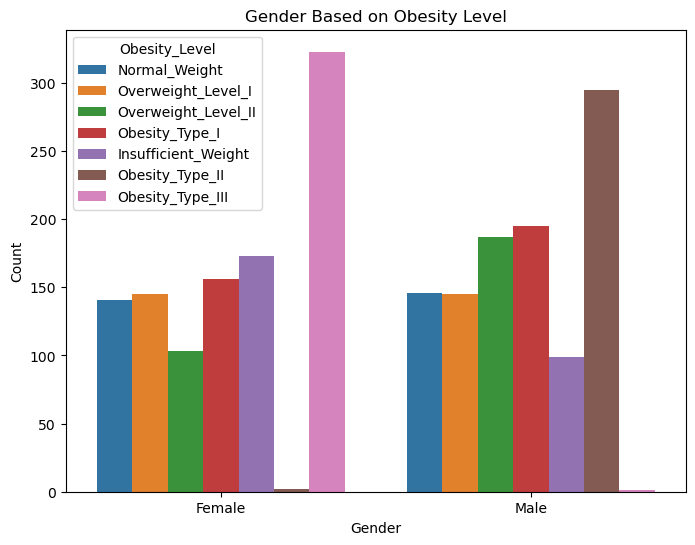

In [20]:
# Count plot for gender based on Obesity level
plt.figure(figsize=(8, 6))
sns.countplot(data=feature_analysis, x='Gender', hue='Obesity_Level')
plt.title('Gender Based on Obesity Level')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig('Images/gender_based_obesity_level.png')
plt.show()

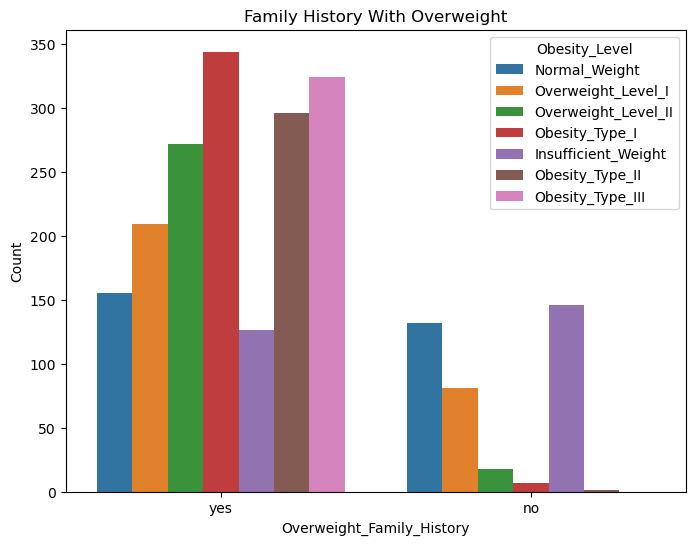

In [21]:
# Count plot for Family History With Overweight based on Obesity level
plt.figure(figsize=(8, 6))
sns.countplot(data=feature_analysis, x='Overweight_Family_History', hue='Obesity_Level')
plt.title('Family History With Overweight')
plt.ylabel('Count')
plt.savefig('Images/family_history_with_overweight_based_on_obesity.png')
plt.show()

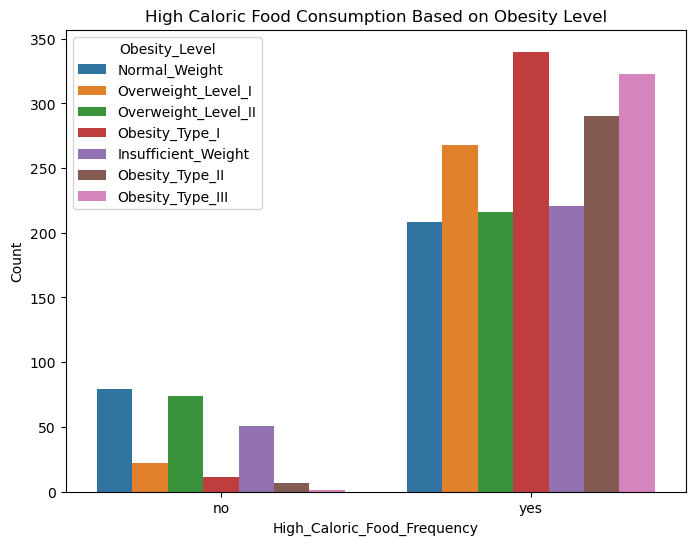

In [22]:
# Count plot for High Caloric Food Frequency based on Obesity level
plt.figure(figsize=(8, 6))
sns.countplot(data=feature_analysis, x='High_Caloric_Food_Frequency', hue='Obesity_Level')
plt.title('High Caloric Food Consumption Based on Obesity Level')
plt.ylabel('Count')
plt.savefig('Images/high_calari_food_based_on_obesity.png')
plt.show()

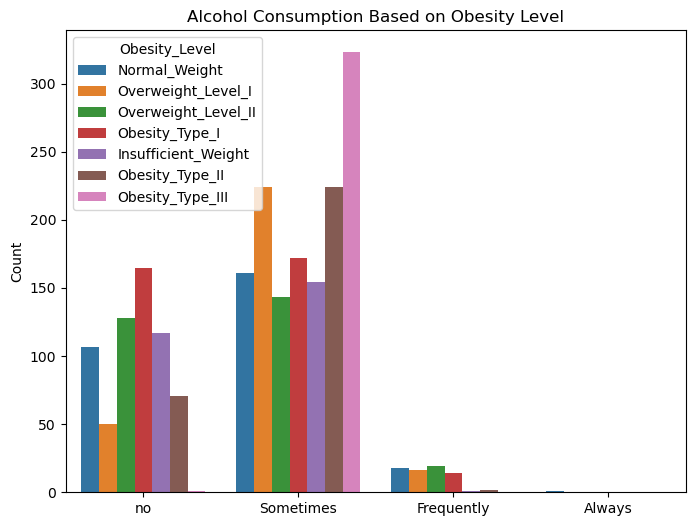

In [23]:
# Count plot for Do You Drink Alcohol based on Obesity level
plt.figure(figsize=(8, 6))
sns.countplot(data=feature_analysis, x='Alcohol_Frequency', hue='Obesity_Level')
plt.title('Alcohol Consumption Based on Obesity Level')
plt.xlabel('')
plt.ylabel('Count')
plt.savefig('Images/alchohol_consumption_based_on_obesity.png')
plt.show()

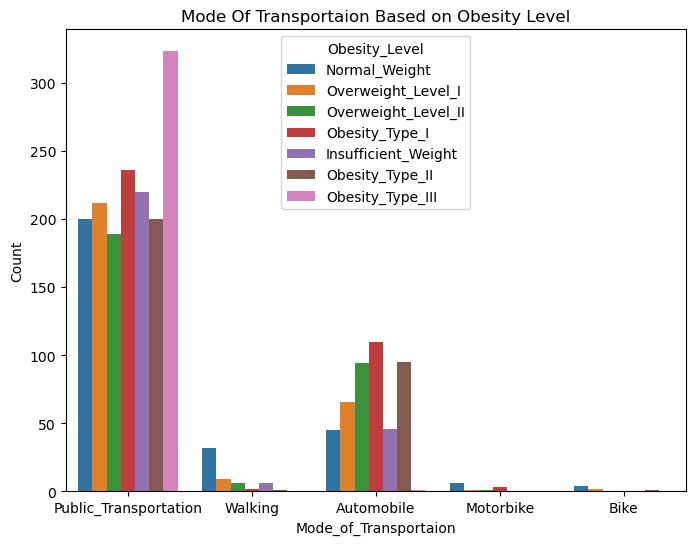

In [24]:
# Count plot for Mode Of Transportaion based on Obesity level
plt.figure(figsize=(8, 6))
sns.countplot(data=feature_analysis, x='Mode_of_Transportaion', hue='Obesity_Level')
plt.title('Mode Of Transportaion Based on Obesity Level')
plt.ylabel('Count')
plt.savefig('Images/mode_of_transportation_based_on_obesity.png')
plt.show()

#### Inspect feature importance

##### With BMI, Height, Weight

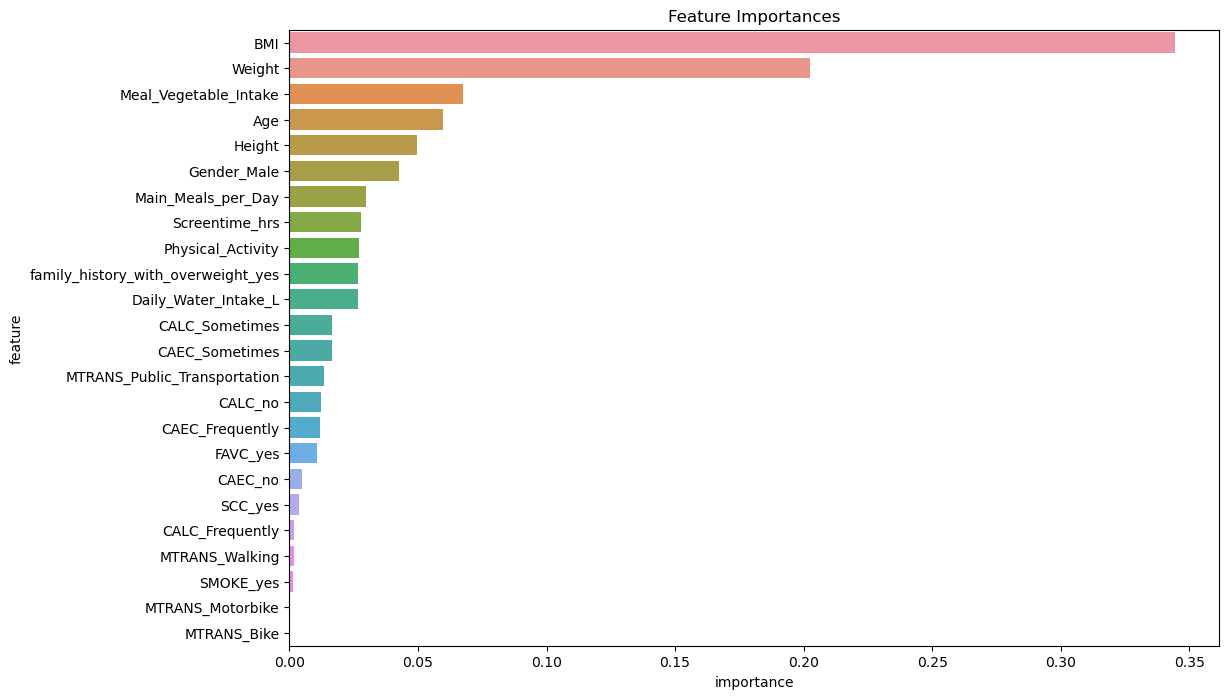

In [25]:
# Split data into features and target variable
X = eda_model_data.drop('NObeyesdad', axis=1).copy()
y = eda_model_data['NObeyesdad'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.savefig('Images/feature_importance.png')
plt.show()

##### Without BMI, Height, Weight.

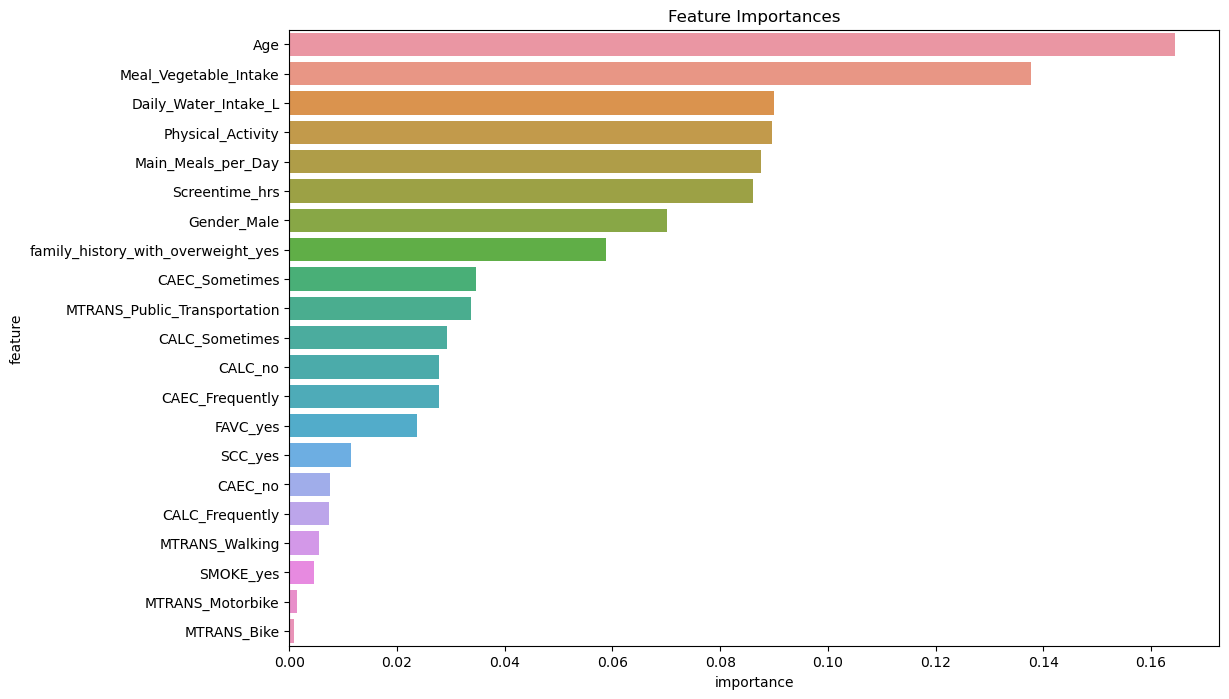

In [26]:
# Split data into features and target variable
X = eda_model_data.drop(['NObeyesdad', 'Height', 'Weight', 'BMI'], axis=1).copy()
y = eda_model_data['NObeyesdad'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.savefig('Images/feature_importance_no_bmi.png')
plt.show()

# Modelling

## Logistic Regression Modelling

#### Fetch datatype conversion table

In [27]:
# Read in datatypes csv
dtype_url = "https://project-4-weight-data.s3.ap-southeast-2.amazonaws.com/database_dtype.csv"
spark.sparkContext.addFile(dtype_url)

# DataFrame is called datatypes
datatypes = (spark.read.csv(SparkFiles.get("database_dtype.csv"), sep=",", header=True)).toPandas()

# Replace datatypes in dataframe to convert the feature/target dataframe
datatypes.replace(['uint8', 'int32'], 'int64')

datatype_dict= {}

for index, row in datatypes.iterrows():
    try:        
        datatype_dict[row['Feature']]= row['Dtype']
    except:
        pass

# Convert datatypes
for key, value in datatype_dict.items():
    try:
        df[key] = df[key].astype(value) 
    except:
        pass

#### With BMI, Height, Weight

In [28]:
# Split data into features and target variable
X = eda_model_data.drop(['NObeyesdad'], axis=1).copy()
y = eda_model_data['NObeyesdad'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Train a Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# OPTIMIZE

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga']
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Evaluate the optimised model on the test set
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Evaluate the optimised model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Save Grid Search results to CSV
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('model_comparison/grid_search_results.csv', index=False)

print(f'Optimized Accuracy: {accuracy_optimized:.2f}')
print(f'Optimized Precision: {precision_optimized:.2f}')
print(f'Optimized Recall: {recall_optimized:.2f}')
print(f'Optimized F1 Score: {f1_optimized:.2f}')

c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.91
Optimized Accuracy: 0.90
Optimized Precision: 0.91
Optimized Recall: 0.90
Optimized F1 Score: 0.90


c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##### Without BMI, Height, Weight

In [29]:
# Split data into features and target variable
X = eda_model_data.drop(['NObeyesdad', 'Height', 'Weight', 'BMI'], axis=1).copy()
y = eda_model_data['NObeyesdad'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Train a Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# OPTIMIZE

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga']
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Evaluate the optimised model on the test set
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Evaluate the optimised model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Save Grid Search results to CSV
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('model_comparison/grid_search_results_no_weight_height.csv', index=False)

print(f'Optimized Accuracy: {accuracy_optimized:.2f}')
print(f'Optimized Precision: {precision_optimized:.2f}')
print(f'Optimized Recall: {recall_optimized:.2f}')
print(f'Optimized F1 Score: {f1_optimized:.2f}')

c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model

Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.66
Optimized Accuracy: 0.70
Optimized Precision: 0.68
Optimized Recall: 0.70
Optimized F1 Score: 0.68


c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## SVM Model

### Model with BMI, Height & Weight

In [30]:
# Feature data
X= dummy_feature_data.copy()

# Target data
y= raw_target_data.copy()

y.apply(weightReplacement)

# Rename columns to make it person-friendly then set datatype as int.
y.rename(columns={'NObeyesdad': 'Obesity_Level'},
         inplace= True)

In [31]:

y['Obesity_Level'] = y['Obesity_Level'].astype(int)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred1 = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test1, y_pred1))

# Generate classification report
report_with_height_and_weight = classification_report(y_test1, y_pred1, output_dict=True)

# Extract metrics for precision, recall, and accuracy
metrics_with_height_and_weight = {
        'Metric': ['Precision', 'Recall', 'Accuracy'],
        'Score': [
            report_with_height_and_weight['weighted avg']['precision'],
            report_with_height_and_weight['weighted avg']['recall'],
            report_with_height_and_weight['accuracy']
        ],
        'Model': ['With Height and Weight'] * 3
    }

# Create DataFrame
df_with_height_and_weight = pd.DataFrame(metrics_with_height_and_weight)
df_with_height_and_weight

c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[118   0   0]
 [  0 105   1]
 [  0   0 199]]


,Metric,Score,Model
0,Precision,0.997648,With Height and Weight
1,Recall,0.997636,With Height and Weight
2,Accuracy,0.997636,With Height and Weight


### Model without BMI, Height & Weight

In [32]:
# Features 
X= dummy_feature_data.drop(['BMI', 'Height', 'Weight'], axis=1).copy()

#Target
y= raw_target_data.copy()

y.apply(weightReplacement)

# Rename columns to make it person-friendly then set datatype as int.
y.rename(columns={'NObeyesdad': 'Obesity_Level'},
         inplace= True)

y['Obesity_Level'] = y['Obesity_Level'].astype(int)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Generate classification report
report_without_height_and_weight = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for precision, recall, and accuracy
metrics_without_height_and_weight = {
        'Metric': ['Precision', 'Recall', 'Accuracy'],
        'Score': [
            report_without_height_and_weight['weighted avg']['precision'],
            report_without_height_and_weight['weighted avg']['recall'],
            report_without_height_and_weight['accuracy']
        ],
        'Model': ['With Height and Weight'] * 3
    }

# Create DataFrame
df_without_height_and_weight = pd.DataFrame(metrics_without_height_and_weight)
df_without_height_and_weight

c:\Users\anups\anaconda3\envs\dev0\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[ 90  13  15]
 [ 19  33  54]
 [  5   8 186]]


,Metric,Score,Model
0,Precision,0.716522,With Height and Weight
1,Recall,0.730496,With Height and Weight
2,Accuracy,0.730496,With Height and Weight


### SVM Comparisons

In [33]:
# Combine the DataFrames
svm_results_df = pd.concat([df_with_height_and_weight, df_without_height_and_weight])
svm_results_df


,Metric,Score,Model
0,Precision,0.997648,With Height and Weight
1,Recall,0.997636,With Height and Weight
2,Accuracy,0.997636,With Height and Weight
0,Precision,0.716522,With Height and Weight
1,Recall,0.730496,With Height and Weight
2,Accuracy,0.730496,With Height and Weight


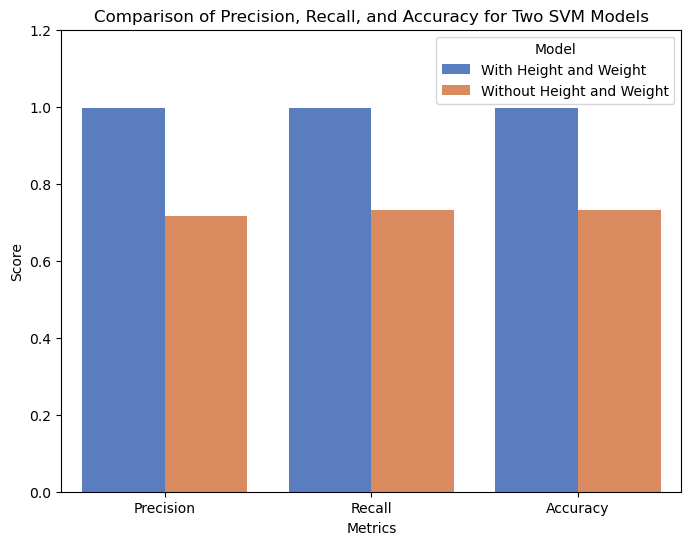

In [34]:
# Generate classification reports
report_with_height_and_weight = classification_report(y_test1, y_pred1, output_dict=True)
report_without_height_and_weight = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for precision, recall, and accuracy
metrics_with_height_and_weight = {
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Score': [
        report_with_height_and_weight['weighted avg']['precision'],
        report_with_height_and_weight['weighted avg']['recall'],
        report_with_height_and_weight['accuracy']
    ],
    'Model': ['With Height and Weight'] * 3
}

metrics_without_height_and_weight = {
    'Metric': ['Precision', 'Recall', 'Accuracy'],
    'Score': [
        report_without_height_and_weight['weighted avg']['precision'],
        report_without_height_and_weight['weighted avg']['recall'],
        report_without_height_and_weight['accuracy']
    ],
    'Model': ['Without Height and Weight'] * 3
}

# Create DataFrames
df_with_height_and_weight = pd.DataFrame(metrics_with_height_and_weight)
df_without_height_and_weight = pd.DataFrame(metrics_without_height_and_weight)

# Combine the DataFrames
df_combined = pd.concat([df_with_height_and_weight, df_without_height_and_weight])

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=df_combined, x='Metric', y='Score', hue='Model', palette='muted')
plt.title('Comparison of Precision, Recall, and Accuracy for Two SVM Models')
plt.ylim(0, 1.2)
plt.legend(title='Model')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.savefig('Images/comparison_of_two_svm_models_plot.png')
plt.show()

# Neural Network Modelling

#### Load data

In [35]:
# Load feature data
X = dummy_feature_data.copy()

# Load target data
y= raw_target_data.copy()

y.apply(weightReplacement)

# Rename columns to make it person-friendly then set datatype as int.
y.rename(columns={'NObeyesdad': 'Obesity_Level'},
         inplace= True)

y['Obesity_Level'] = y['Obesity_Level'].astype(int)

nn_data = pd.concat([X, y], axis= 1).copy()

In [36]:
#### Create a dictionary to hold the NN Model accuracy information
nn_outcome_dictionary = {"Network_Model": [],
                         "Height_&_Weight": [],
                         "Neurons": [],
                         "Hidden_Layers": [],
                         "Activation_Function": [],
                         "Accuracy": [],
                         "Loss": []}

# Process Target data to allow binary target evaluation.

# Split target data to identify Obese/Overweight OR Not.

weight_target_sort = nn_data.copy()

weight_target_sort['Obesity_Level'].replace({0: 0,
                                    1: 0,
                                    2: 1,
                                    3: 1},
                                    inplace= True)

neuralNetworkModel(weight_target_sort, "obese_overweight_or_not", "Yes")
neuralNetworkModelNoHeightWeight(weight_target_sort, "obese_overweight_or_not", "No")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                1736      
                                                                 
 dense_1 (Dense)             (None, 25)                1425      
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3,837
Trainable params: 3,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
50/50 [==============================] - 1s 5ms/step - loss: 0.3827 - accuracy: 0.8497
Epoch 2/60
50/50 [==============================] - 0s 2ms/step - loss: 0.1792 - accurac

In [37]:
# Split target data to identify Obese OR Overweight.

obesity_sort = nn_data.copy()

obesity_sort = obesity_sort.loc[obesity_sort['Obesity_Level'] > 1]


obesity_sort['Obesity_Level'].replace({2: 0,
                                    3: 1},
                                    inplace= True)
neuralNetworkModel(obesity_sort, "obese_or_overweight", "Yes")
neuralNetworkModelNoHeightWeight(obesity_sort, "obese_or_overweight", "No")

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 56)                1736      
                                                                 
 dense_163 (Dense)           (None, 25)                1425      
                                                                 
 dense_164 (Dense)           (None, 25)                650       
                                                                 
 dense_165 (Dense)           (None, 1)                 26        
                                                                 
Total params: 3,837
Trainable params: 3,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
37/37 [==============================] - 1s 3ms/step - loss: 0.6377 - accuracy: 0.6615
Epoch 2/60
37/37 [==============================] - 0s 3ms/step - loss: 0.3992 - accu

In [38]:
nn_model_ouctomes = pd.DataFrame(nn_outcome_dictionary)
nn_model_ouctomes.to_csv('model_comparison/nn_evaluation.csv')
model= set(nn_outcome_dictionary['Network_Model'])
obese_overweight= set(nn_outcome_dictionary['Height_&_Weight'])

top_nn_outcomes_dict= {"Network_Model": [],
                         "Height_&_Weight": [],
                         "Neurons": [],
                         "Hidden_Layers": [],
                         "Activation_Function": [],
                         "Accuracy": [],
                         "Loss": []}

for i in model:
    for j in obese_overweight:
        accuracy_df= ((nn_model_ouctomes.loc[(nn_model_ouctomes['Network_Model'] == i) & (nn_model_ouctomes['Height_&_Weight'] == j)].sort_values('Accuracy', ascending= False)).reset_index(drop= True)).copy()
        for each in accuracy_df.columns:
            top_nn_outcomes_dict[each].append(accuracy_df[each][0])

top_nn_outcomes= pd.DataFrame(top_nn_outcomes_dict)
top_nn_outcomes.to_csv('model_comparison/top_nn_evaluation.csv')